<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.07.31_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 간단한 GAN 구조 정의
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

# 모델, 손실함수, 옵티마이저 정의
latent_dim = 100
generator = Generator(latent_dim) #D(G(z)) -> 0
discriminator = Discriminator()   #D(x) -> 1

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

device = 'cuda'

generator.to(device)
discriminator.to(device)
None

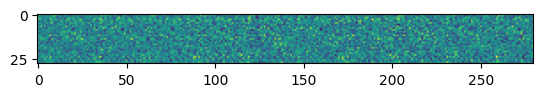

In [5]:
#generate
def generate_and_display():
    import matplotlib.pyplot as plt
    z = torch.randn(10, latent_dim) #10, 100
    generator.eval()
    with torch.no_grad():
                                                                 #-1 ~ 1
        image = (generator(z.to(device)).reshape(-1, 28, 28) * 127.5 + 127).cpu().numpy()
    plt.imshow(image.transpose(1, 0, 2).reshape(28, 10*28))
    plt.show()
generate_and_display()

Epoch [1/20] 	 D_loss: 0.0243, G_loss: 4.6175


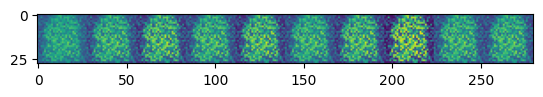

Epoch [2/20] 	 D_loss: 0.1300, G_loss: 5.3118


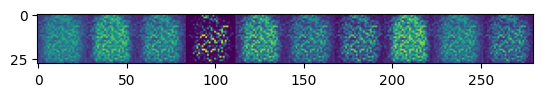

Epoch [3/20] 	 D_loss: 0.3635, G_loss: 4.3624


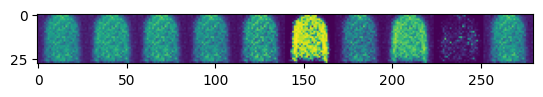

Epoch [4/20] 	 D_loss: 0.1316, G_loss: 3.6646


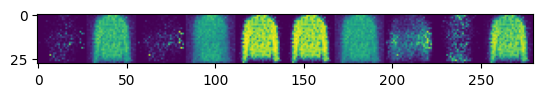

Epoch [5/20] 	 D_loss: 0.4498, G_loss: 3.2661


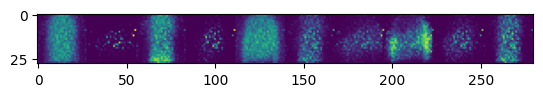

Epoch [6/20] 	 D_loss: 0.2178, G_loss: 3.9801


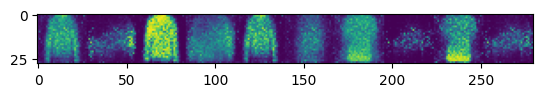

Epoch [7/20] 	 D_loss: 0.0550, G_loss: 5.8359


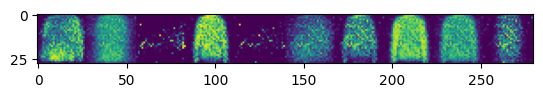

Epoch [8/20] 	 D_loss: 0.3013, G_loss: 4.1208


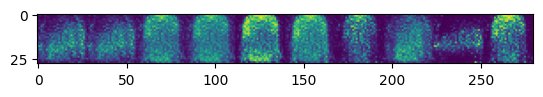

Epoch [9/20] 	 D_loss: 0.2555, G_loss: 4.6936


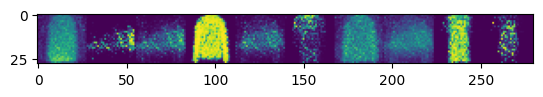

Epoch [10/20] 	 D_loss: 0.3514, G_loss: 3.4870


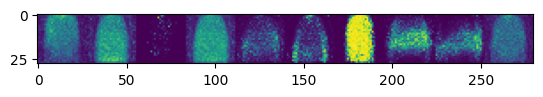

Epoch [11/20] 	 D_loss: 0.4261, G_loss: 3.2630


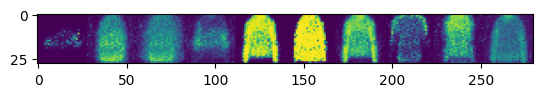

Epoch [12/20] 	 D_loss: 0.4637, G_loss: 3.0574


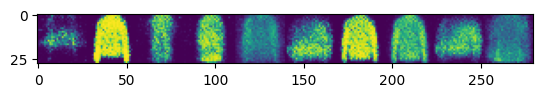

Epoch [13/20] 	 D_loss: 0.3615, G_loss: 2.5490


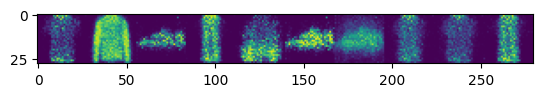

Epoch [14/20] 	 D_loss: 0.4705, G_loss: 3.8027


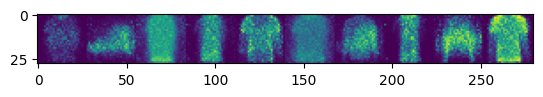

Epoch [15/20] 	 D_loss: 0.4248, G_loss: 3.3710


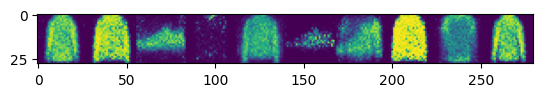

Epoch [16/20] 	 D_loss: 0.3874, G_loss: 2.2772


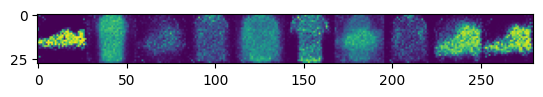

Epoch [17/20] 	 D_loss: 0.8491, G_loss: 2.4362


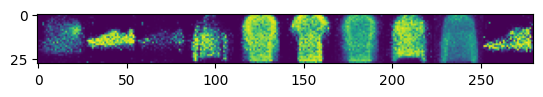

Epoch [18/20] 	 D_loss: 0.6289, G_loss: 2.5985


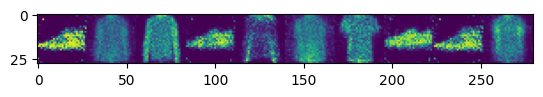

Epoch [19/20] 	 D_loss: 0.5024, G_loss: 3.0818


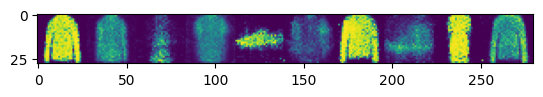

Epoch [20/20] 	 D_loss: 0.3763, G_loss: 2.9343


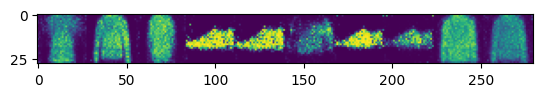

In [6]:
# 학습 과정
for epoch in range(20):
    for imgs, _ in dataloader:
        batch_size = imgs.size(0)
        imgs = imgs.view(batch_size, -1)

        # 진짜 이미지 학습
        real_labels = torch.ones(batch_size, 1).to(device)   #1
        fake_labels = torch.zeros(batch_size, 1).to(device)  #0

        outputs = discriminator(imgs.to(device))
        d_loss_real = criterion(outputs, real_labels)

        # 가짜 이미지 학습
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z.to(device))
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator 학습 (Discriminator 고정 및 eval 모드)
        discriminator.eval()
        discriminator.requires_grad_(False) #-> 가중치 고정
        # for param in discriminator.parameters():
        #     param.requires_grad = False

        outputs_fake = discriminator(fake_images)
        g_loss = criterion(outputs_fake, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        discriminator.train()
        for param in discriminator.parameters():
            param.requires_grad = True

    print(f'Epoch [{epoch+1}/20] \t D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

    generate_and_display()
